In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, reduce, repeat

In [2]:
# Create "S" shaped data
x_region1 = torch.linspace(0, 2, 150)
x_region2 = torch.linspace(1, 3, 150)
x_region3 = torch.linspace(2, 4, 150)

f1 = lambda x: 2*x - 1
f2 = lambda x: -2*x + 6
f3 = lambda x: torch.tensor([0.5]*len(x))

f1_x = f1(x_region1)
f2_x = f2(x_region2)
f3_x = f3(x_region3)

x_total = torch.cat([x_region1, x_region2, x_region3])
f_total = torch.cat([f1_x, f2_x, f3_x])

y_total = f_total + torch.randn_like(f_total)*0.2

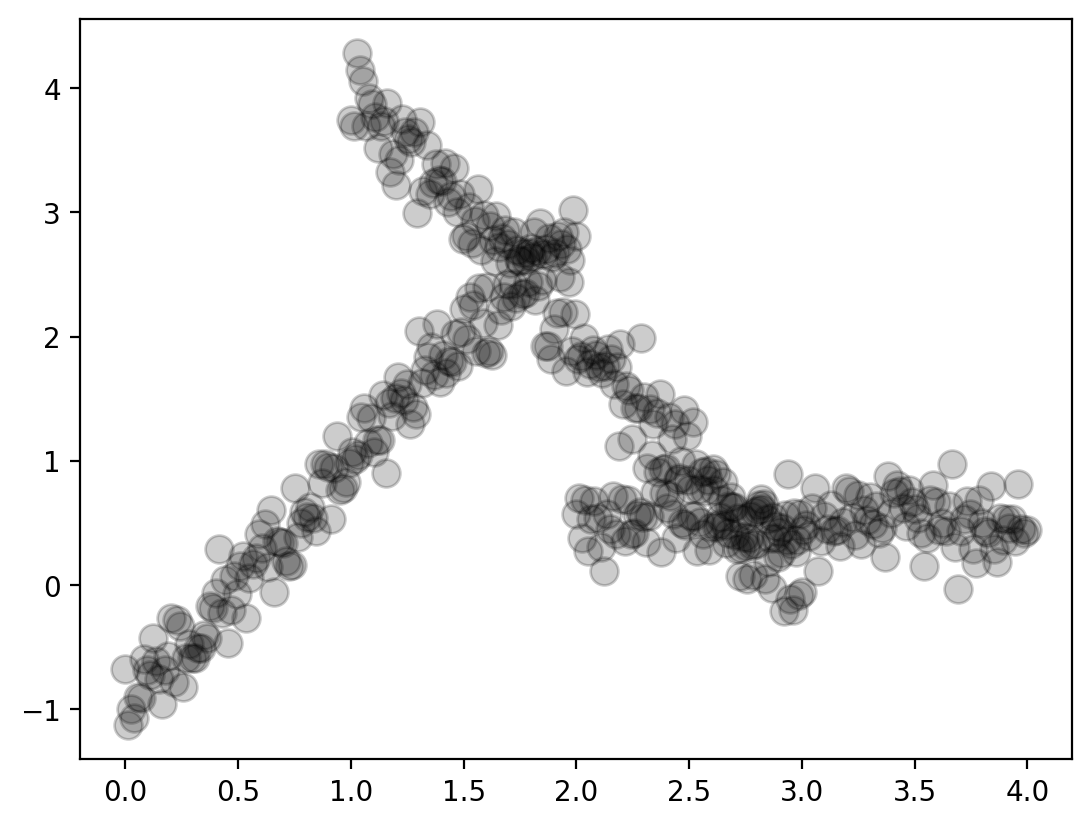

In [3]:
plt.plot(x_total, y_total, 'o', ms=10, c='k', alpha=0.2)

In [4]:
class Linear(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)


In [5]:
e1 = Linear(1, 1)
e2 = Linear(1, 1)
e3 = Linear(1, 1)

In [6]:
class Gating(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        pred = F.softmax(self.linear(x), dim=1)
        return pred
        


In [7]:
g = Gating(1, 3)

In [8]:
x_test = torch.linspace(0, 4, 100).view(-1, 1)
weights = g(x_test)
print(weights.shape)

torch.Size([100, 3])


In [9]:
predictions = torch.cat([e1(x_test), e2(x_test), e3(x_test)], dim=1)
print(predictions.shape)

torch.Size([100, 3])


In [10]:
overall_prediction = torch.sum(weights*predictions, dim=1)
print(overall_prediction.shape)

torch.Size([100])


In [11]:
def predict(g, e1, e2, e3, x):
    weights = g(x)
    predictions = torch.cat([e1(x),
                            e2(x),
                            e3(x)], dim=1)
    overall_prediction = torch.sum(weights*predictions, dim=1)
    return overall_prediction

In [12]:
def plot(g, e1, e2, e3, x_test):
    y_hat = predict(g, e1, e2, e3, x_test).detach().numpy()
    plt.plot(x_region1, f1_x,  lw=3, label='f1')
    plt.plot(x_region2, f2_x,  lw=3, label='f2')
    plt.plot(x_region3, f3_x,  lw=3, label='f3')
    plt.plot(x_total, y_total, 'o', ms=5, c='k', alpha=0.1, label='data')
    plt.plot(x_test, y_hat, 'r', lw=3, label='Overall prediction')
    # prediction of each expert
    y_hat_e1 = e1(x_test).detach().numpy()
    y_hat_e2 = e2(x_test).detach().numpy()
    y_hat_e3 = e3(x_test).detach().numpy()
    plt.plot(x_test, y_hat_e1, '--', lw=2, label='Expert 1')
    plt.plot(x_test, y_hat_e2, '--', lw=2, label='Expert 2')
    plt.plot(x_test, y_hat_e3, '--', lw=2, label='Expert 3')
    # legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

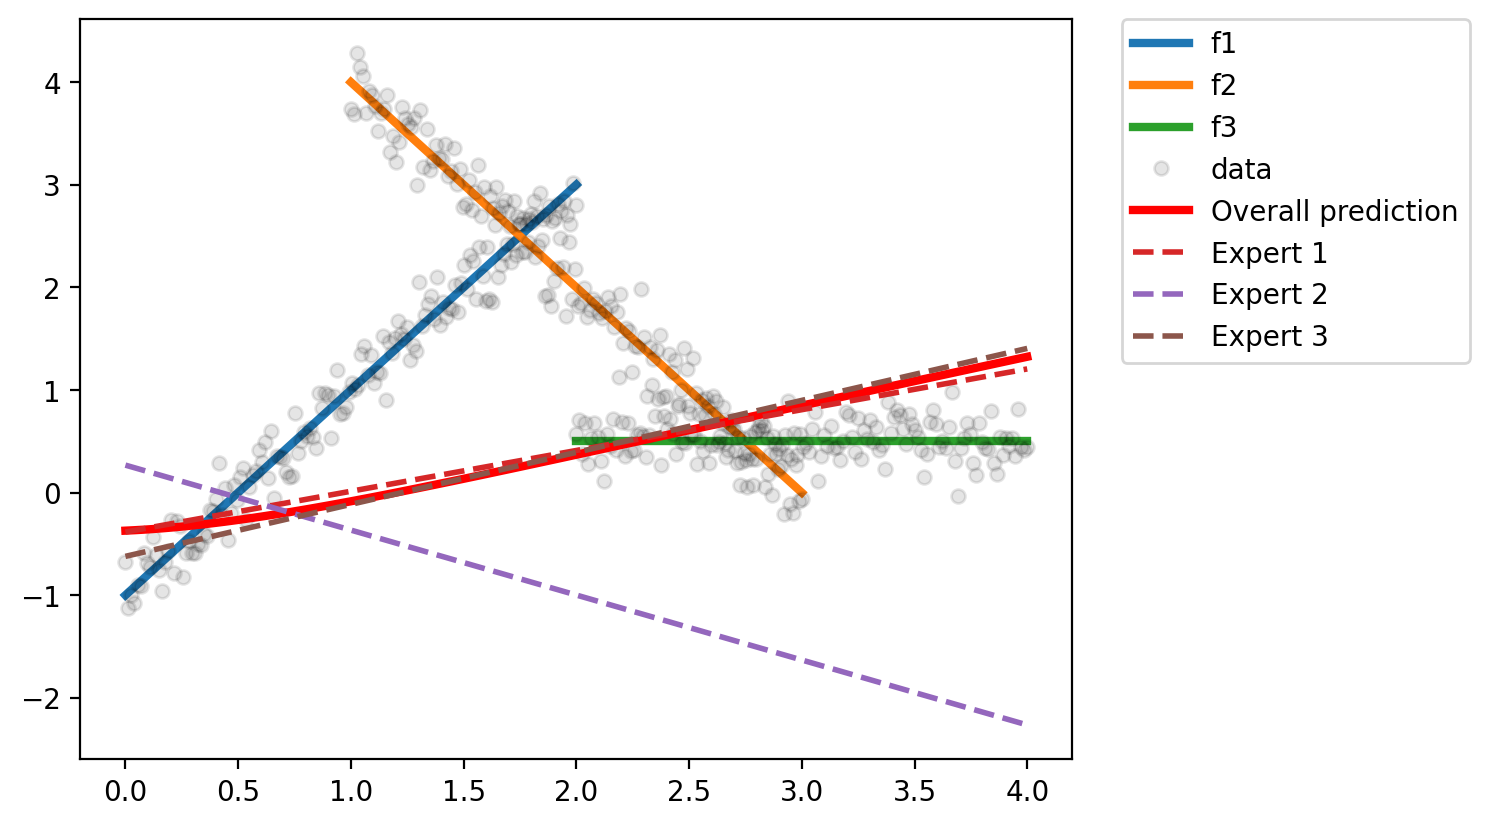

In [13]:
plot(g, e1, e2, e3, x_test)

In [14]:
optimizer = torch.optim.Adam(list(e1.parameters()) + 
                             list(e2.parameters()) + 
                             list(e3.parameters()) + 
                             list(g.parameters()), lr=0.01)

for i in range(5000):
    optimizer.zero_grad()
    loss = torch.mean((y_total - predict(g, e1, e2, e3, x_total.view(-1, 1)))**2)
    loss.backward()
    optimizer.step()
    if i % 500 == 0:
        print(loss.item())

2.34350848197937
0.3760591149330139
0.34844234585762024
0.3476337492465973
0.34751665592193604
0.34749242663383484
0.34747281670570374
0.34743985533714294
0.347318172454834
0.33742383122444153


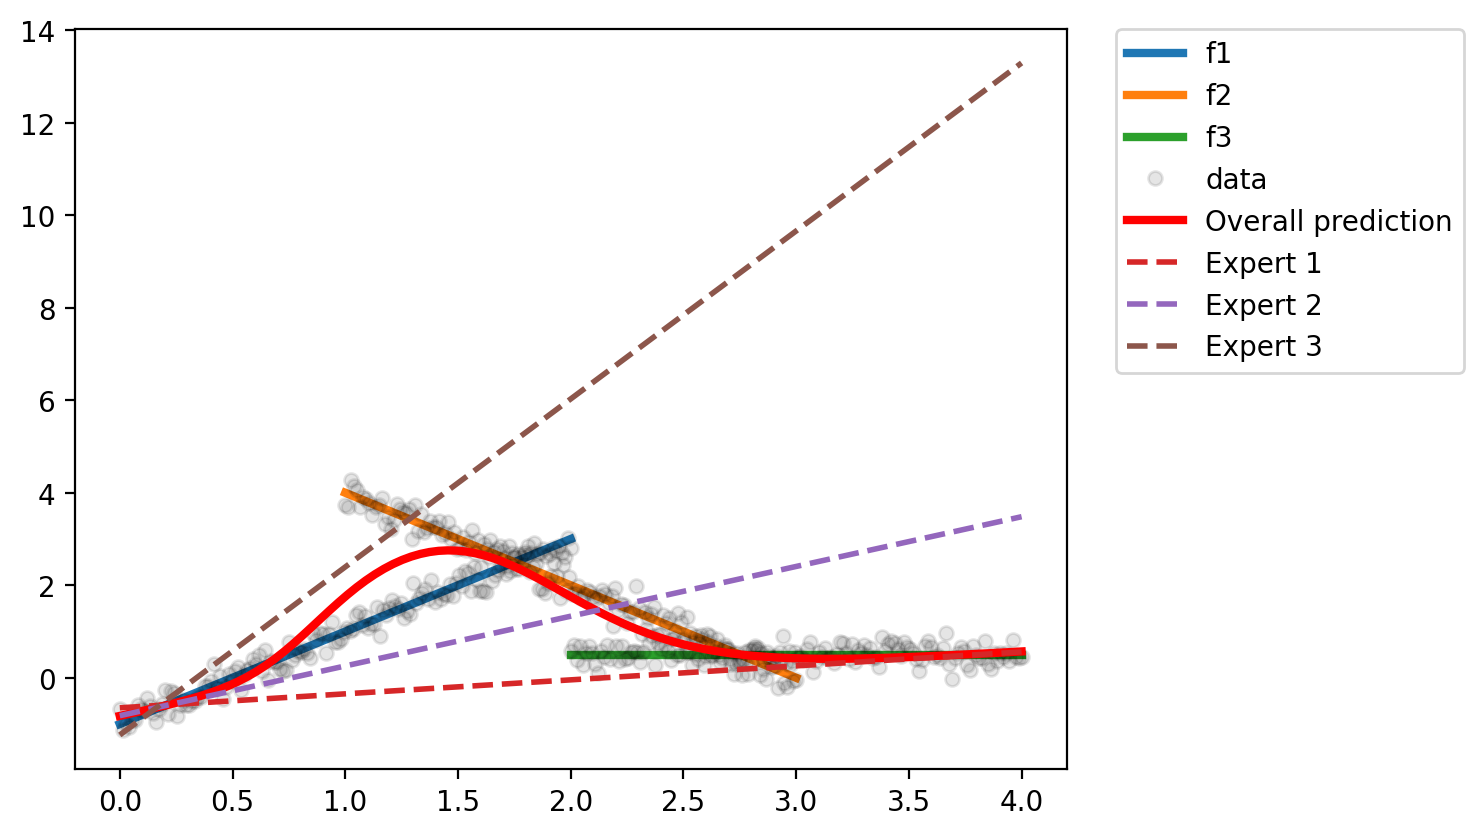

In [15]:
plot(g, e1, e2, e3, x_test)

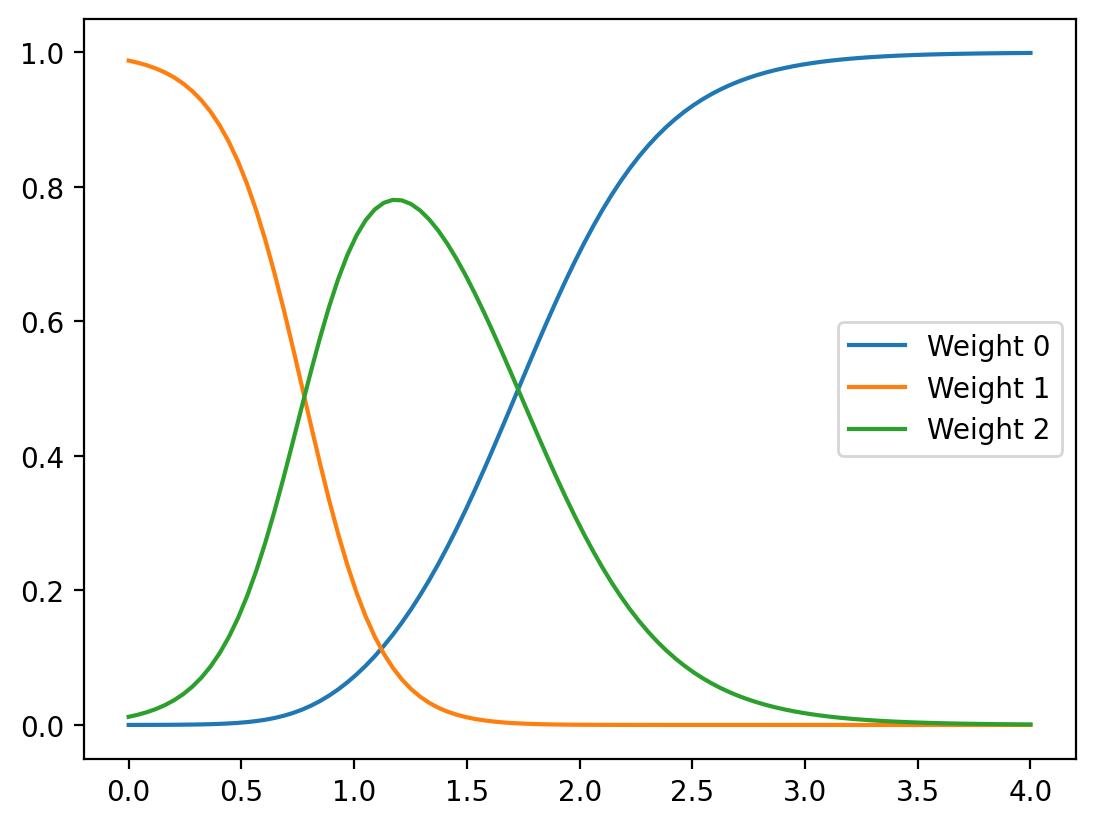

In [16]:
weights = g(x_test).detach().numpy()
for i in range(3):
    plt.plot(x_test, weights[:, i], label=f'Weight {i}')
plt.legend()